## Spatiotemporal energy models for the perception of motion 
[paper](https://opg.optica.org/josaa/viewmedia.cfm?uri=josaa-2-2-284&html=true)

There was some confusion about the meaning of spatiotemporal filter phase during my presentation, hopefully this helps clarify. Happy to talk more about this if you have ideas or spot bugs.

In [4]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage.measure import block_reduce

In [5]:
def gauss1d(x, mu, sigma):
    return (1/sigma*np.sqrt(2*np.pi))*np.exp(-1/2*((x-mu)**2)/sigma**2)

def gauss_2der(x, gauss, sigma):
    """2nd derivative of 1D Gaussian."""
    return ((-sigma**2+x**2)/sigma**4)*gauss

def gauss_3der(x, gauss2der):
    """3rd derivative of 1D Gaussian."""
    dx = x[1]-x[0]
    return np.gradient(gauss2der, dx)

# code from http://vision.psych.umn.edu/users/kersten/kersten-lab/courses/Psy5036W2017/Lectures/17_PythonForVision/Demos/html/2b.Gabor.html
def gen_sinusoid(sz, amp, freq, phase):
    radius = (int(sz/2.0), int(sz/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))
    sinusoid = amp * np.cos(freq[0] * x  + freq[1] * y + phase)
    return sinusoid

def gen_gabor(sz, freq, theta, func=np.cos, K=np.pi):
    radius = (int(sz/2.0), int(sz/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))

    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)

    gauss = freq**2 / (4*np.pi * K**2) * np.exp(- freq**2 / (8*K**2) * ( 4 * x1**2 + y1**2))
    sinusoid = func(freq * x1) * np.exp(K**2 / 2)
    sinusoid = func(freq * x1) * np.exp(K**2 / 2)
    gabor = gauss * sinusoid
    return gabor

def gen_fig8_stim(sz):
    half = sz//2
    still = sz//9
    stim = np.zeros((sz, sz))
    stim[:still, :half] = 1
    stim[:still, half:] = 0
    stim[sz-still:, :half] = 1
    stim[sz-still:, half:] = 0
    j = 0
    for i in range(still, sz-still):
        idx = int((sz/2 + sz/5*np.sin(j)))
        stim[i, :idx] = 1
        stim[i, idx:] = 0
        j+=2*np.pi/(sz-(still*2))
    return stim

## Recreating Fig. 6
Separable filter by outer product of spatial and temporal impulse functions.

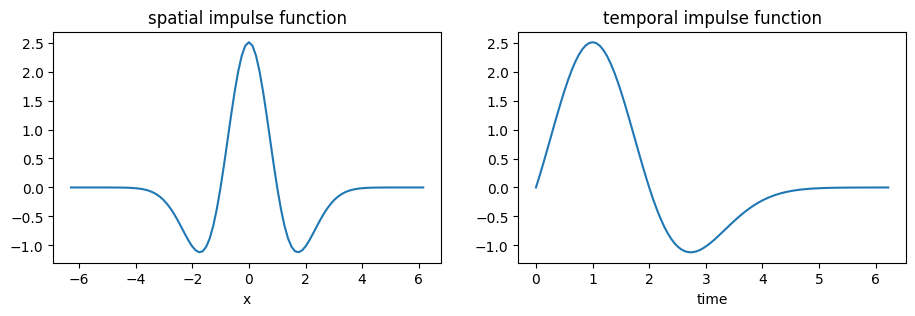

In [6]:
nsamples = 100
sigma = 1

xs = np.linspace(-2*np.pi, 2*np.pi, nsamples, endpoint=False)
gauss = gauss1d(xs, 0, sigma)
spatial = -gauss_2der(xs, gauss, sigma)

xt = np.linspace(0, 2*np.pi, nsamples, endpoint=False)
gauss = gauss1d(xt-1, 0, sigma)
temporal = -gauss_2der(xt-1, gauss, sigma)

fig = plt.gcf()
fig.set_size_inches(11, 3)
axes = fig.subplots(nrows=1, ncols=2)
axes[0].plot(xs, spatial)
axes[0].set_title("spatial impulse function")
axes[0].set_xlabel("x")

axes[1].plot(xt, temporal)
axes[1].set_title("temporal impulse function")
axes[1].set_xlabel("time")

plt.show()

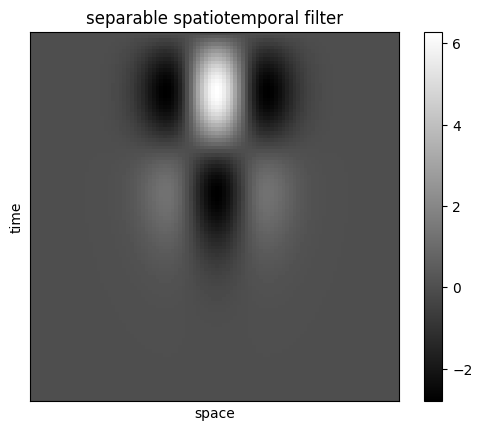

In [7]:
separable = np.outer(temporal, spatial)
plt.imshow(separable, cmap="gray")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel("space")
plt.ylabel("time")
plt.title("separable spatiotemporal filter")
plt.show()

## Demonstrating the effect of phase
See page 7, section 5 first paragraph for how they describe the phase issue.

Below: stimulus as in Fig. 15a, quadrature pair Gabor filters as in Fig. 9a. 

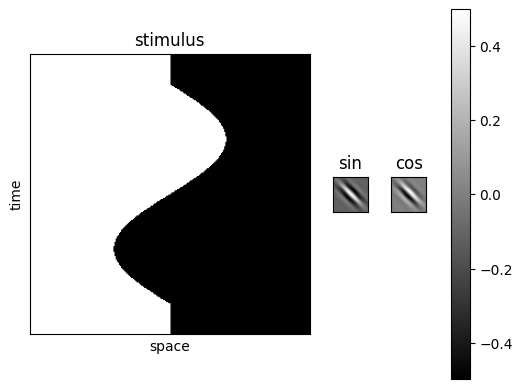

In [8]:
sz = 256
stim = gen_fig8_stim(sz)

theta = -np.pi/4
sz = 32
gabor_sin = gen_gabor(sz, np.sin(theta), theta, func=np.cos)
gabor_cos = gen_gabor(sz, np.cos(theta), theta, func=np.sin)

ims = [stim, gabor_sin, gabor_cos]
titles = ["stimulus", "sin", "cos"]

fig = plt.gcf()
gridspec_kw={'width_ratios': [8, 1, 1]}
axes = fig.subplots(nrows=1, ncols=3, gridspec_kw=gridspec_kw)
for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(ims[i], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    if i ==0:
        ax.set_ylabel("time")
        ax.set_xlabel("space")
    ax.set_title(titles[i])
plt.colorbar(im, ax=axes)
plt.show()

(ignore convolution boundary artifacts) 
Below, the top row is the above stimulus convolved with sine (left) and cosine (right, as in Fig. 8f) Gabors. Bottom row is the above stimulus with reversed contrast (black on left, white on right), again convolved with sine and cosine Gabors. 

Although the velocity and direction of the movement of the edge is the same in all of them, the intensity values are different in the resulting images. This is due to how the stimulus happens to line up with the two filters, which vary only by phase. A phase-invariant filter should produce all identical and uniform colors (like in Fig. 15b), regardless of the contrast of the stimulus, or how it happens to line up with the filter during convolution.

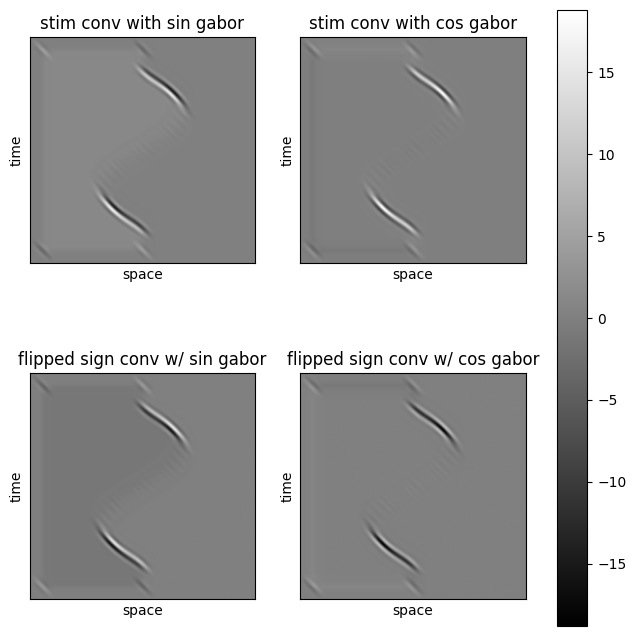

In [9]:
sin_convolve = convolve2d(stim, gabor_sin)
cos_convolve = convolve2d(stim, gabor_cos)
flip_sin_convolve = convolve2d(-stim, gabor_sin)
flip_cos_convolve = convolve2d(-stim, gabor_cos)

ims = [sin_convolve, cos_convolve, flip_sin_convolve, flip_cos_convolve]
vmin = np.min(ims)
vmax = np.max(ims)
titles = ["stim conv with sin gabor", "stim conv with cos gabor", "flipped sign conv w/ sin gabor", "flipped sign conv w/ cos gabor"]

fig = plt.gcf()
fig.set_size_inches(8, 8)
axes = fig.subplots(nrows=2, ncols=2)
for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(ims[i], vmin=vmin, vmax=vmax, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel("time")
    ax.set_xlabel("space")
    ax.set_title(titles[i])

plt.colorbar(im, ax=axes)
plt.show()


Below, we apply the square+sum trick and we get a phase-invariant response, meaning that the response to both the stimulus and its flipped contrast version are the same.

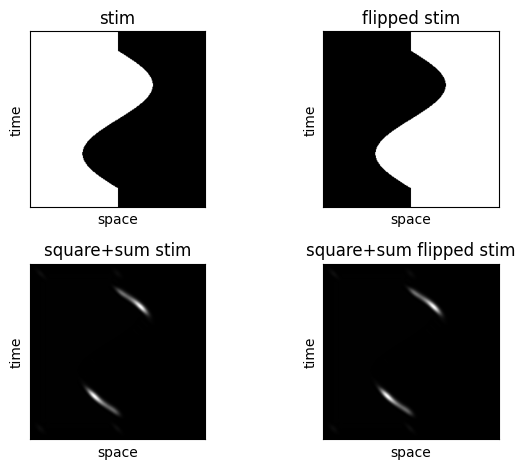

In [10]:
invariant_stim = sin_convolve**2 + cos_convolve**2
invariant_flip_stim = flip_sin_convolve**2 + flip_cos_convolve**2

ims = [stim, -stim, invariant_stim, invariant_flip_stim]
titles = ["stim", "flipped stim", "square+sum stim", "square+sum flipped stim"]

fig = plt.gcf()
axes = fig.subplots(nrows=2, ncols=2)
for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(ims[i], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel("time")
    ax.set_xlabel("space")
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

What happens when we try convolving with a sinusoidal pattern as suggested on page 7? This is a one-dimensional sinusoid moving to the right continuously, at a constant velocity.

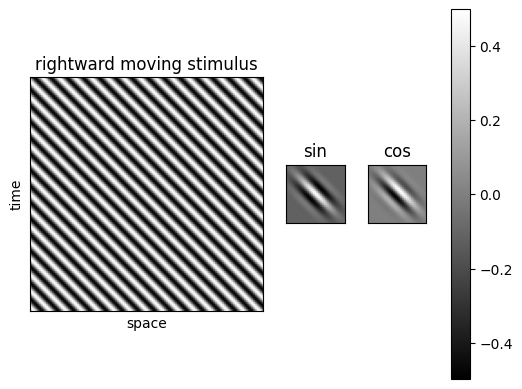

In [21]:
theta = -np.pi/4
freq = [np.cos(theta), np.sin(theta)]
phase = np.pi/2
amp = 1
stim_sz = 128
sinusoid = gen_sinusoid(stim_sz, amp, freq, phase)

sz = 32
gabor_sin = gen_gabor(sz, np.sin(theta), theta, func=np.cos)
gabor_cos = gen_gabor(sz, np.cos(theta), theta, func=np.sin)

ims = [sinusoid, gabor_sin, gabor_cos]
titles = ["rightward moving stimulus", "sin", "cos"]

fig = plt.gcf()
gridspec_kw={'width_ratios': [4, 1, 1]}
axes = fig.subplots(nrows=1, ncols=3, gridspec_kw=gridspec_kw)
for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(ims[i], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    if i ==0:
        ax.set_ylabel("time")
        ax.set_xlabel("space")
    ax.set_title(titles[i])
plt.colorbar(im, ax=axes)
plt.show()


Below, convolved with sine and cosine filters. The blue dot is in the same location for both images, to demonstrate change of phase. Even though we'd like the output to be uniform because the stimulus is moving at a constant velocity, the outputs are not uniform and are not equivalent to each other. And since the outputs are not equivalent, and the filters differ only in phase, the system is clearly phase-dependent.

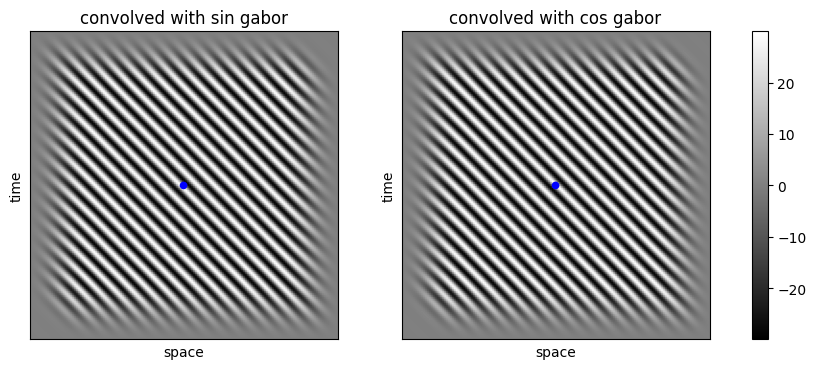

In [12]:
sin_convolve = convolve2d(sinusoid, gabor_sin)
cos_convolve = convolve2d(sinusoid, gabor_cos)
h = sin_convolve.shape[0]
radius=2

fig = plt.gcf()
fig.set_size_inches(11, 4)
axes = fig.subplots(nrows=1, ncols=2)
im = axes[0].imshow(sin_convolve, cmap="gray")
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_ylabel("time")
axes[0].set_xlabel("space")
circle = patches.Circle((h//2, h//2), radius=radius, facecolor='blue')
axes[0].add_patch(circle)
axes[0].set_title("convolved with sin gabor")

im = axes[1].imshow(cos_convolve, cmap="gray")
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_ylabel("time")
axes[1].set_xlabel("space")
circle = patches.Circle((h//2, h//2), radius=radius, facecolor='blue')
axes[1].add_patch(circle)
axes[1].set_title("convolved with cos gabor")

plt.colorbar(im, ax=axes)
plt.show()

And once again applying the trick, we get constant motion:


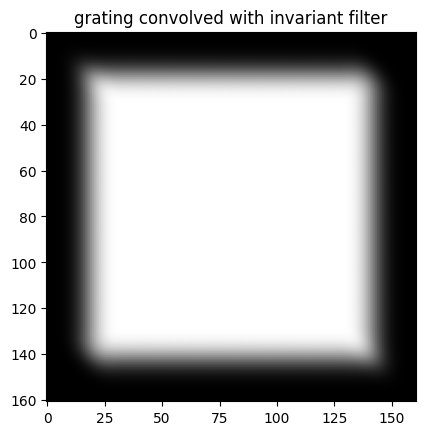

In [13]:
invariant = sin_convolve**2 + cos_convolve**2
plt.imshow(invariant, cmap="gray")
plt.title("grating convolved with invariant filter")
plt.show()

## Recreating Fig. 10
They don't show all their parameters so I've done my best to approximate what is shown in the figures.

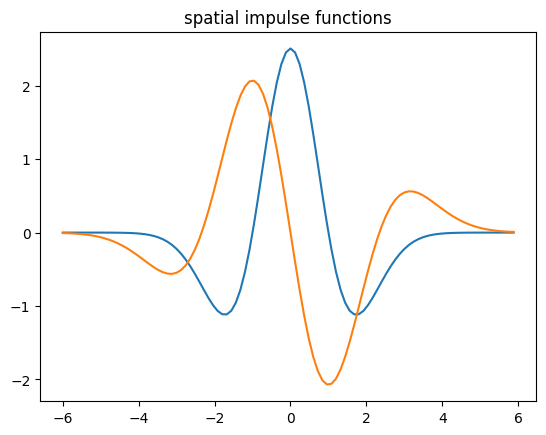

In [14]:
# spatial
sigma = 1
x = np.linspace(-6, 6, nsamples, endpoint=False)
gauss = gauss1d(x, 0, sigma) 
gauss2der = gauss_2der(x, gauss, sigma)

gauss3der = gauss1d(x, 0, 1.35) 
gauss3der = gauss_2der(x, gauss3der, 1.35)
dx = x[1]-x[0]
gauss3der = np.gradient(gauss3der, dx)

spat1 = -gauss2der
spat2 = -2*gauss3der
plt.plot(x, spat1)
plt.plot(x, spat2)
plt.title("spatial impulse functions")
plt.show()

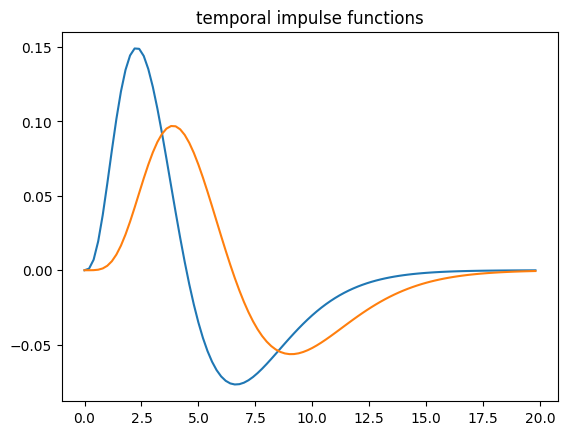

In [15]:
# temporal
def temporal_filter(t, n, k=1):
    return (k*t)**n*np.exp(-k*t)*(1/np.math.factorial(n)-((k*t)**2/np.math.factorial(n+2)))

x = np.linspace(0, 20, nsamples, endpoint=False)
temp1 = temporal_filter(x, n=3)
temp2 = temporal_filter(x, n=5)
plt.plot(x, temp1)
plt.plot(x, temp2)
plt.title("temporal impulse functions")
plt.show()

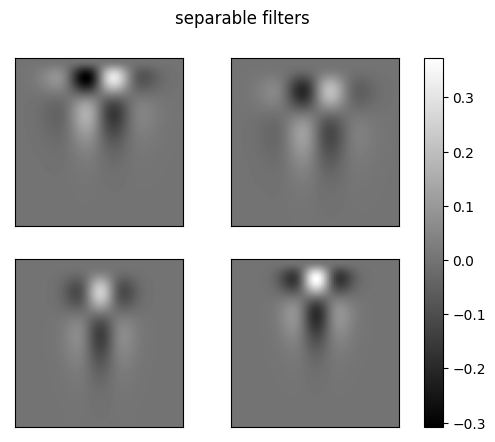

In [16]:
# create the four separable filters
filt1 = -np.outer(temp1, spat2)
filt2 = -np.outer(temp2, spat2)
filt3 = np.outer(temp2, spat1)
filt4 = np.outer(temp1, spat1)
filters = [filt1, filt2, filt3, filt4]

vmin = np.min(filters)
vmax = np.max(filters)

fig = plt.gcf()
axes = fig.subplots(nrows=2, ncols=2)
for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(filters[i], vmin=vmin, vmax=vmax, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle("separable filters")
plt.colorbar(im, ax=axes)
plt.show()

The below are created from linear combinations of the above.

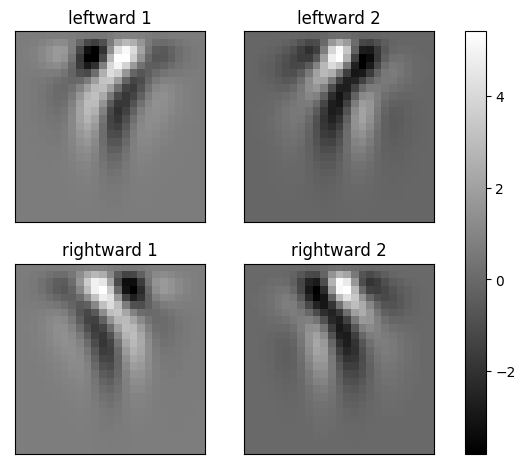

In [17]:
l1 = block_reduce(filt1+filt3, 4)
l2 = block_reduce(-filt2+filt4, 4)
r1 = block_reduce(-filt1+filt3, 4)
r2 = block_reduce(filt2+filt4, 4)
filters = [l1, l2, r1, r2]
titles = ["leftward 1", "leftward 2", "rightward 1", "rightward 2"]

fig = plt.gcf()
axes = fig.subplots(nrows=2, ncols=2)
for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(filters[i], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i])
plt.tight_layout()
plt.colorbar(im, ax=axes) # note: image colors not all to scale
plt.show()

Below, convolved with the two rightward filters. Same as earlier in the notebook, the filters are phase-dependent.

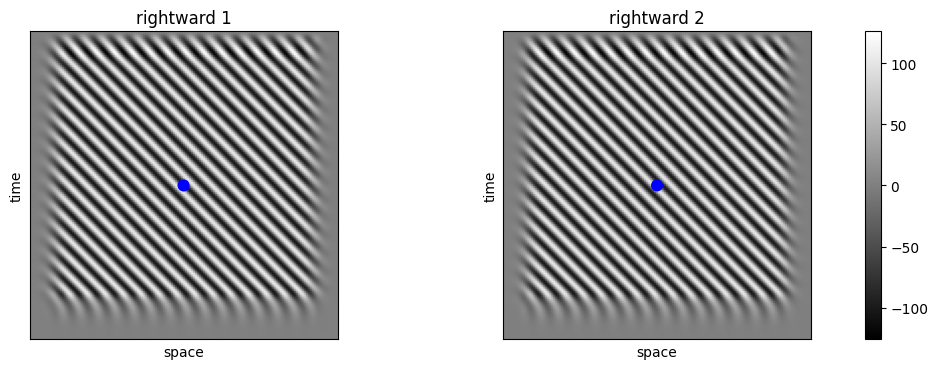

In [18]:
sinusoid_r1 = convolve2d(sinusoid, r1)
sinusoid_r2 = convolve2d(sinusoid, r2)
h = sinusoid_r1.shape[0]

ims = [sinusoid_r1, sinusoid_r2]
titles = ["rightward 1", "rightward 2"]

fig = plt.gcf()
fig.set_size_inches(14, 4)
axes = fig.subplots(nrows=1, ncols=2)
for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(ims[i], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel("time")
    ax.set_xlabel("space")
    ax.set_title(titles[i])
    circle = patches.Circle((h//2, h//2), radius=3, facecolor='blue')
    ax.add_patch(circle)

plt.colorbar(im, ax=axes)
plt.show()

Now we convolve with the invariant versions of the separable filters.

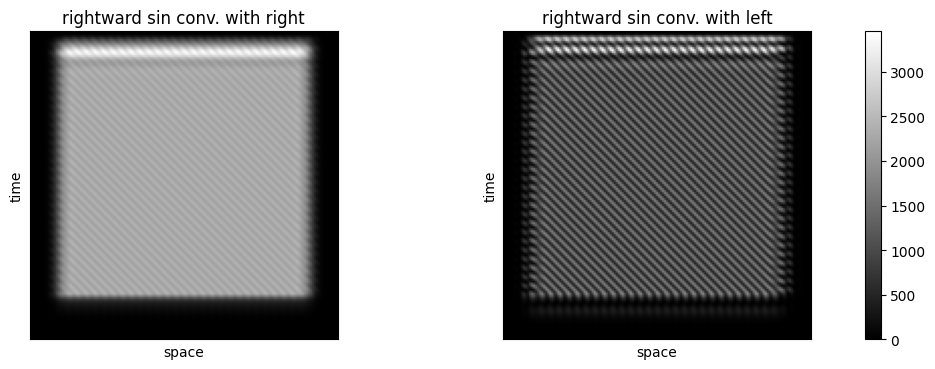

In [22]:
sinusoid_r = sinusoid_r1**2 + sinusoid_r2**2

sinusoid_l1 = convolve2d(sinusoid, l1)
sinusoid_l2 = convolve2d(sinusoid, l2)
sinusoid_l = sinusoid_l1**2 + sinusoid_l2**2

ims = [sinusoid_r, sinusoid_l]
titles = ["rightward sin conv. with right", "rightward sin conv. with left"]

fig = plt.gcf()
fig.set_size_inches(14, 4)
axes = fig.subplots(nrows=1, ncols=2)
for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(ims[i], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel("time")
    ax.set_xlabel("space")
    ax.set_title(titles[i])

plt.colorbar(im, ax=axes)
plt.show()

The above isn't perfect because the filter frequencies aren't exactly aligned with the grating, but ideally you would see all white for the right filter and all black for the leftward filter (because there is only rightward motion in the stimulus).

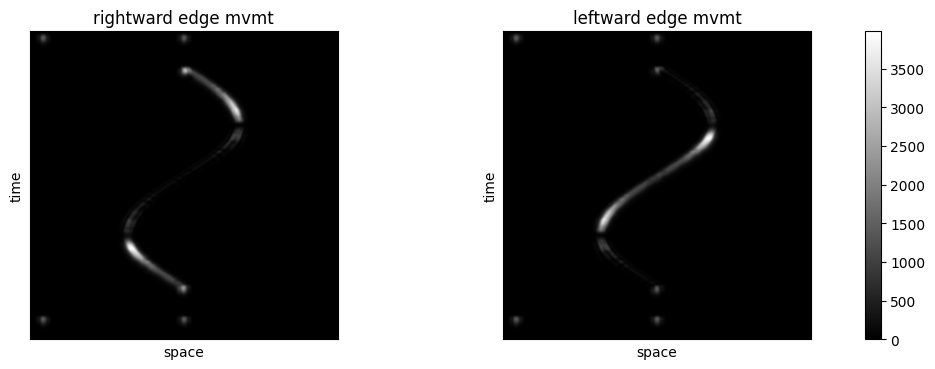

In [20]:
stim_r1 = convolve2d(stim, r1)
stim_r2 = convolve2d(stim, r2)
edge_right = stim_r1**2 + stim_r2**2
stim_l1 = convolve2d(stim, l1)
stim_l2 = convolve2d(stim, l2)
edge_left = stim_l1**2 + stim_l2**2

ims = [edge_right, edge_left]
titles = ["rightward edge mvmt", "leftward edge mvmt"]

fig = plt.gcf()
fig.set_size_inches(14, 4)
axes = fig.subplots(nrows=1, ncols=2)
for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(ims[i], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel("time")
    ax.set_xlabel("space")
    ax.set_title(titles[i])

plt.colorbar(im, ax=axes)
plt.show()

The above is what we expect as shown in Fig. 15b,c.